In [1]:
import numpy as np
import pandas as pd
import seaborn as sns

from matplotlib import pyplot as plt
from sklearn.model_selection import KFold
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import Ridge
from sklearn.tree import DecisionTreeRegressor
from sklearn.feature_selection import chi2, mutual_info_regression, f_regression
from sklearn.feature_selection import RFECV
from sklearn.feature_selection import SelectKBest

In [2]:
ins_data = pd.read_pickle('../../data/feature engineered/insurance.pkl')
ins_data

,age,sex,bmi,children,smoker,region,charges
0,-0.854167,-1.0,-0.304319,-0.5,-0.590433,0.000000,0.475094
1,-1.020833,0.0,0.389592,0.0,0.000000,1.000000,-1.302772
2,-0.447917,0.0,0.302496,1.0,0.000000,1.000000,-0.585858
3,-0.239583,0.0,-0.987437,-0.5,0.000000,0.000000,0.692467
4,-0.281250,0.0,-0.183343,-0.5,0.000000,0.000000,-0.693955
...,...,...,...,...,...,...,...
1333,0.468750,0.0,0.067477,1.0,0.000000,0.000000,0.097725
1334,-1.020833,-1.0,0.178465,-0.5,0.000000,-0.025641,-1.119708
1335,-1.020833,-1.0,0.727647,-0.5,0.000000,1.000000,-1.345025
1336,-0.739583,-1.0,-0.571484,-0.5,0.000000,0.000000,-1.190043


In [3]:
Y = ins_data.loc[:, 'charges']
X = ins_data.drop('charges', axis=1)

In [4]:
X.shape, Y.shape

((1338, 6), (1338,))

****feature selection****

- Recursive feature elimination

In [5]:
rfcv_estimator = Ridge()
rfcv_model = RFECV(estimator=rfcv_estimator, step=1, cv=KFold(10))
rfcv_model.fit(X, Y)

RFECV(cv=KFold(n_splits=10, random_state=None, shuffle=False),
      estimator=Ridge())

In [6]:
rfcv_model.ranking_, rfcv_model.support_, rfcv_model.grid_scores_

(array([1, 1, 1, 1, 1, 1]),
 array([ True,  True,  True,  True,  True,  True]),
 array([0.45234756, 0.74089084, 0.75614481, 0.76219686, 0.76167365,
        0.76439415]))

In [7]:
rfcv_estimator_tree = DecisionTreeRegressor(min_samples_leaf=25)
rfcv_model_tree = RFECV(estimator=rfcv_estimator_tree, step=1, cv=KFold(10))
rfcv_model_tree.fit(X, Y)

RFECV(cv=KFold(n_splits=10, random_state=None, shuffle=False),
      estimator=DecisionTreeRegressor(min_samples_leaf=25))

In [8]:
rfcv_model_tree.ranking_, rfcv_model_tree.support_, rfcv_model_tree.grid_scores_

(array([1, 1, 1, 1, 1, 1]),
 array([ True,  True,  True,  True,  True,  True]),
 array([0.45239407, 0.77539503, 0.79750992, 0.82772253, 0.82679899,
        0.83201452]))

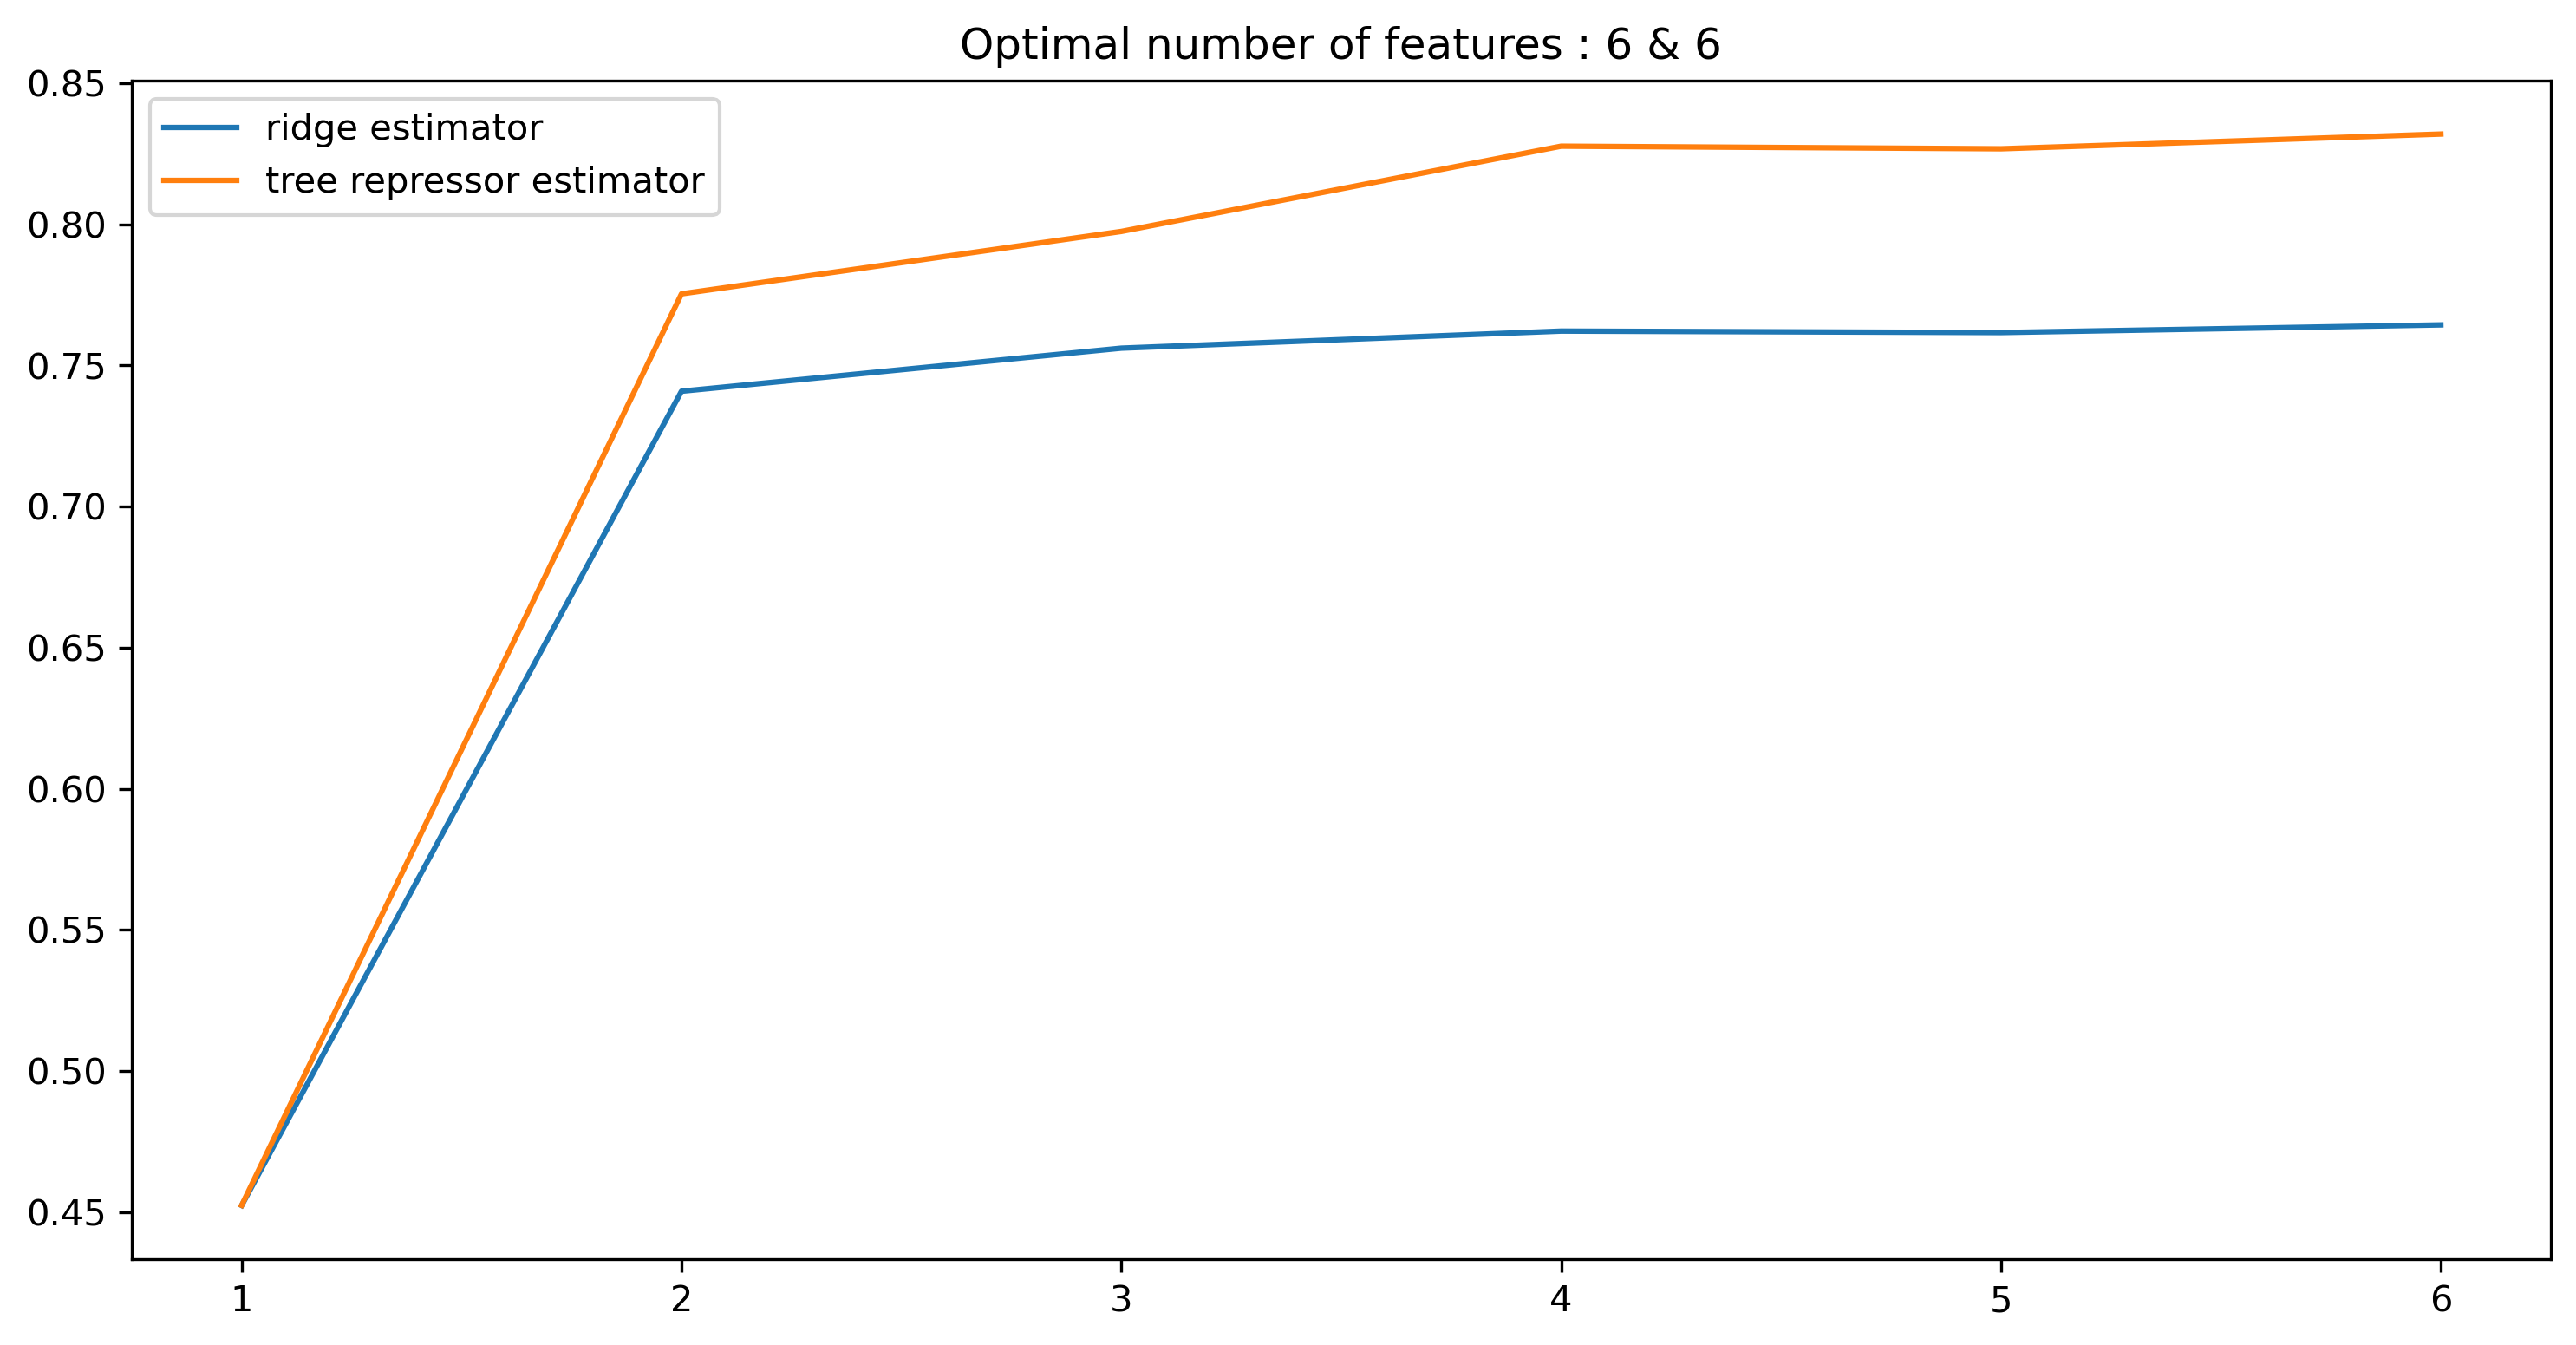

In [9]:
plt.figure(figsize=[12, 6], dpi=300)
sns.lineplot(x=range(1, len(rfcv_model.grid_scores_) + 1), y=rfcv_model.grid_scores_,
             label='ridge estimator')
sns.lineplot(x=range(1, len(rfcv_model_tree.grid_scores_) + 1), y=rfcv_model_tree.grid_scores_,
             label='tree repressor estimator')
plt.legend()
plt.title(f'Optimal number of features : {rfcv_model.n_features_} & {rfcv_model_tree.n_features_}')
plt.savefig('../../demo/feature_selection_rfecv.png')
plt.show()

- Uni-variate feature selection

In [10]:
mireg_selection = SelectKBest(score_func=mutual_info_regression, k=4)
freg_selection = SelectKBest(score_func=f_regression, k=4)

mireg_selection.fit(X, Y)
freg_selection.fit(X, Y)

SelectKBest(k=4, score_func=<function f_regression at 0x00000298E5D9B620>)

In [11]:
mireg_selection.n_features_in_, mireg_selection.scores_, mireg_selection.pvalues_

(6,
 array([1.50651393, 0.17628529, 0.07031475, 0.16093565, 0.36938827,
        0.07811743]),
 None)

In [12]:
freg_selection.n_features_in_, freg_selection.scores_, freg_selection.pvalues_

(6,
 array([4.97690548e+02, 1.01006031e-01, 2.62708520e+01, 3.34596991e+01,
        1.12221960e+03, 4.24058966e-01]),
 array([5.73042765e-094, 7.50675347e-001, 3.40326645e-007, 9.05038846e-009,
        4.10149955e-179, 5.15030605e-001]))

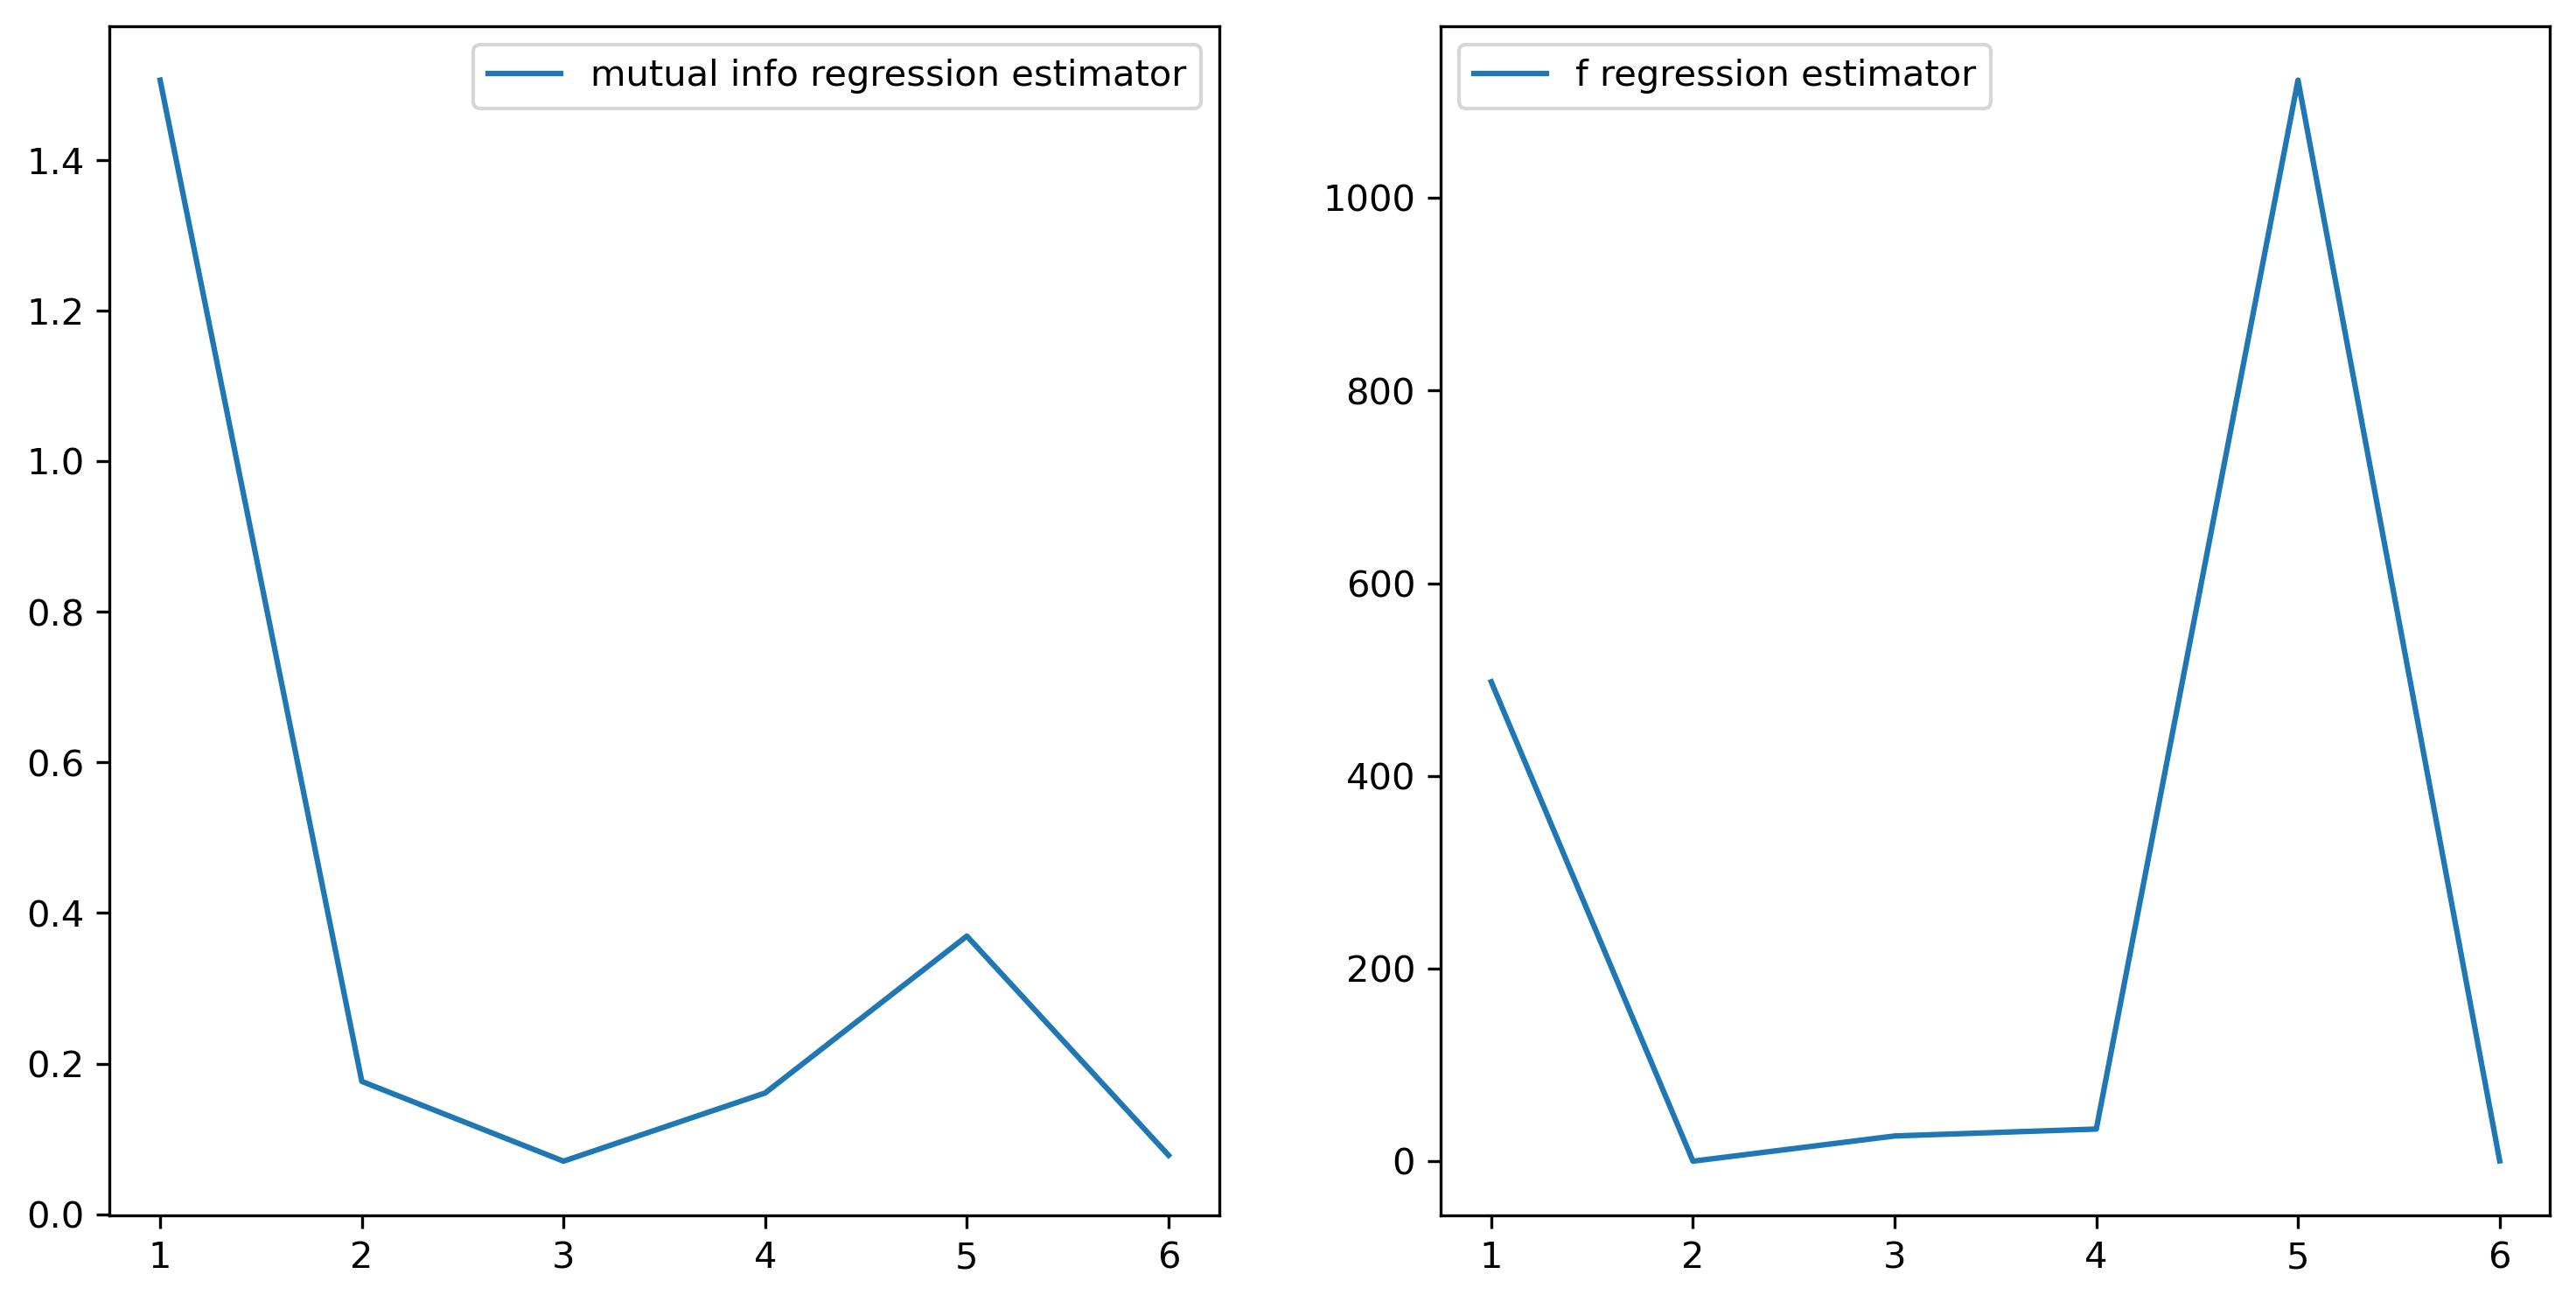

In [13]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=[12, 6], dpi=300)
axes = axes.ravel()

sns.lineplot(x=range(1, mireg_selection.n_features_in_ + 1),
             y=mireg_selection.scores_,
             label='mutual info regression estimator',
             ax=axes[0])
sns.lineplot(x=range(1, freg_selection.n_features_in_ + 1),
             y=freg_selection.scores_,
             label='f regression estimator',
             ax=axes[1])
plt.legend()
plt.savefig('../../demo/Model Creation/feature_selection_select_k_best.png')
plt.show()

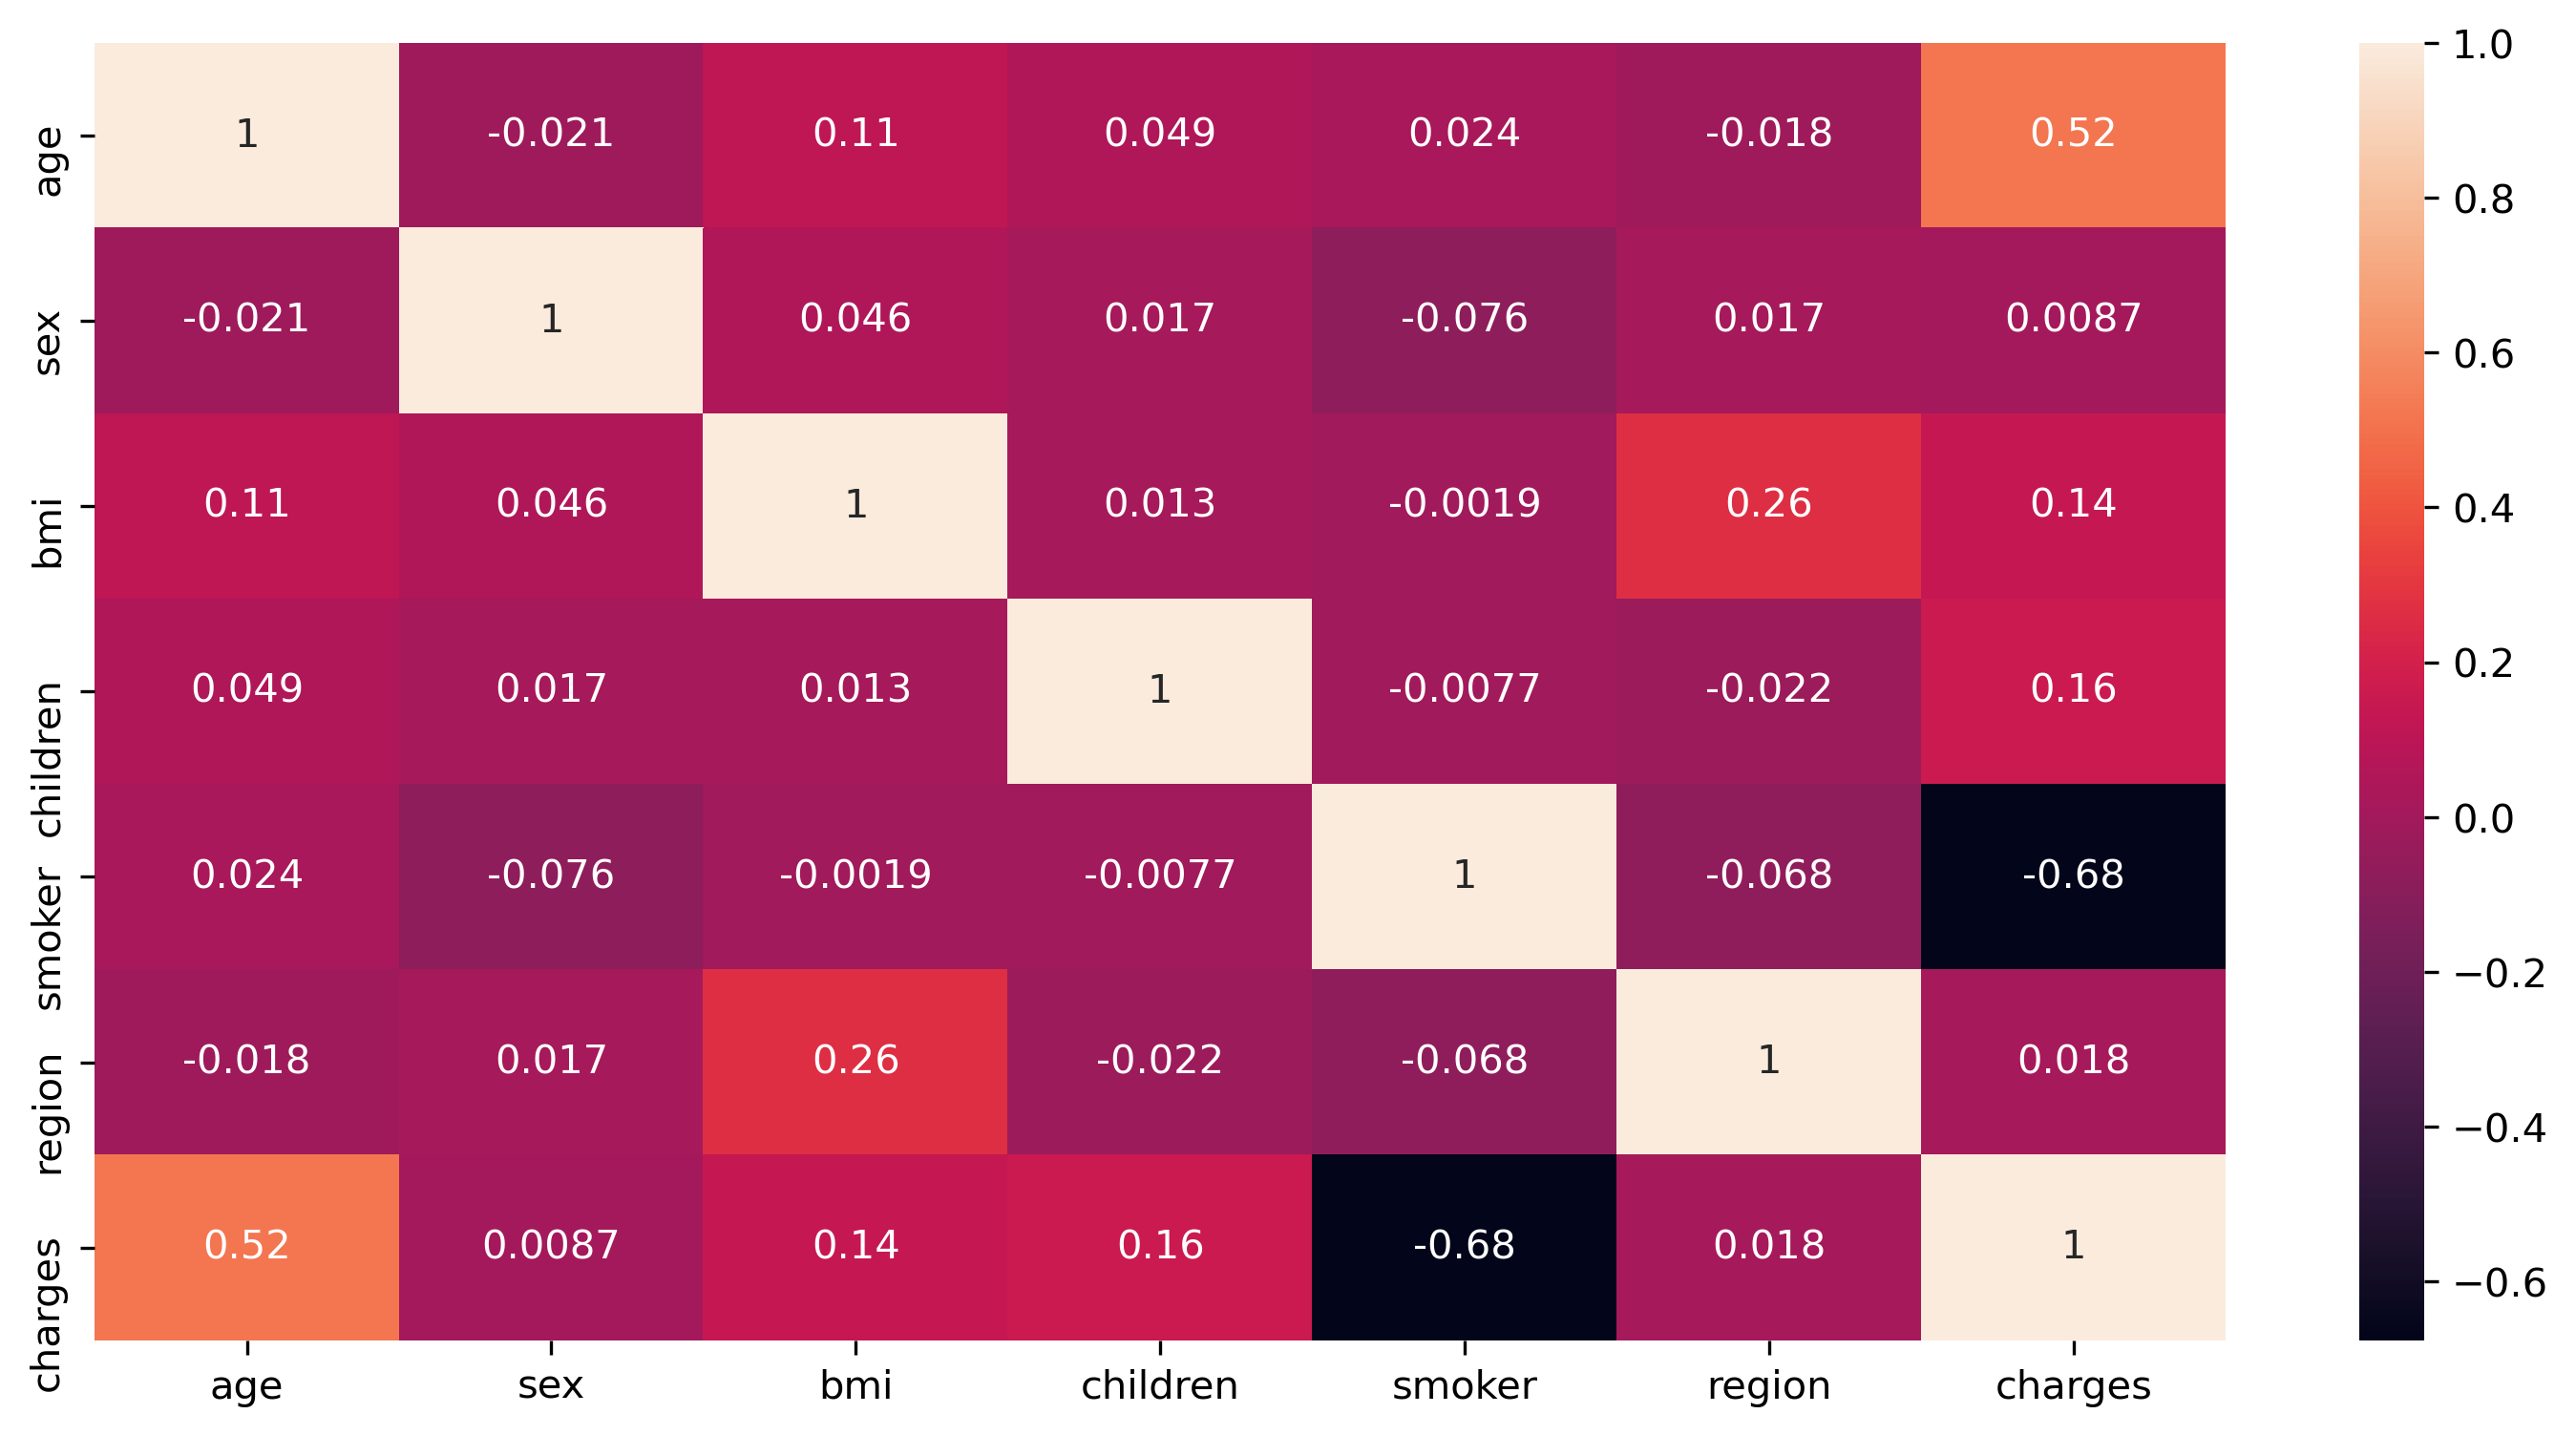

In [14]:
plt.figure(figsize=[12, 6], dpi=300)
sns.heatmap(ins_data.corr(), annot=True, robust=True)
plt.savefig('../../demo/Model Creation/correlation map.png')
plt.show()

In [15]:
df = freg_selection.transform(X)
df = pd.DataFrame(df, columns=['age', 'bmi', 'children', 'smoker'])
df

,age,bmi,children,smoker
0,-0.854167,-0.304319,-0.5,-0.590433
1,-1.020833,0.389592,0.0,0.000000
2,-0.447917,0.302496,1.0,0.000000
3,-0.239583,-0.987437,-0.5,0.000000
4,-0.281250,-0.183343,-0.5,0.000000
...,...,...,...,...
1333,0.468750,0.067477,1.0,0.000000
1334,-1.020833,0.178465,-0.5,0.000000
1335,-1.020833,0.727647,-0.5,0.000000
1336,-0.739583,-0.571484,-0.5,0.000000


## modeling

In [47]:
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.model_selection import RepeatedKFold
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge, Lasso, ElasticNet
from sklearn.linear_model import RANSACRegressor, HuberRegressor

****Ordinary Least Squares****

In [17]:
OLS_model = LinearRegression()

In [18]:
scores = cross_val_score(OLS_model, df, Y, cv=12, scoring='r2')
scores

array([0.80262884, 0.78188217, 0.77513224, 0.65769915, 0.69361417,
       0.81418679, 0.8503388 , 0.83383535, 0.77940138, 0.66475726,
       0.63361968, 0.81431229])

**coefficient of determination** or R2, It measures the amount of variance of the
prediction which is explained by the dataset. R2 values close to 1 mean an ***almost-perfect
regression***, while values close to 0 (or negative) imply a ***bad model***.

In [19]:
print(f'average score: {np.mean(scores) * 100}\n'
      f'standard deviation: {np.std(scores)}')

avarage score: 75.84506771788713
standard deviation: 0.07204578323244683


**Explained variance**

it's helpful to know how much original variance can be explained by the model. This concept is
useful to understand the amount of information that we lose by approximating the dataset. When
this value is small, it means that the data generating process has strong oscillations and a
linear model fails to capture them.

In [20]:
ev = cross_val_score(OLS_model, df, Y, cv=12, scoring='explained_variance')
ev

array([0.80438655, 0.78248166, 0.77516379, 0.65951145, 0.69361423,
       0.81450625, 0.85159102, 0.84375641, 0.77942468, 0.66875776,
       0.66249534, 0.81509089])

In [21]:
print(f'average score: {np.mean(ev) * 100}\n'
      f'standard deviation: {np.std(ev)}')

avarage score: 76.25650007093294
standard deviation: 0.06876967079787309


The low standard deviation confirms that this dataset is not much sensitive to the split strategy.
In some cases, the probability distribution of both training and test sets are rather similar,
and in other situations (at least three with 12 folds), they are same; hence, the
algorithm can learn to predict correctly.

In [22]:
x_train, x_test, y_train, y_test = train_test_split(df, Y, train_size=0.8, random_state=64)
x_train.shape, x_test.shape, y_train.shape, y_test.shape

((1070, 4), (268, 4), (1070,), (268,))

In [23]:
OLS_model.fit(x_train, y_train)
ols_predictions = OLS_model.predict(x_test)

In [24]:
OLS_model.intercept_, OLS_model.coef_

(-0.2837468618695444,
 array([ 0.64256998,  0.08012706,  0.14415849, -2.0999057 ]))

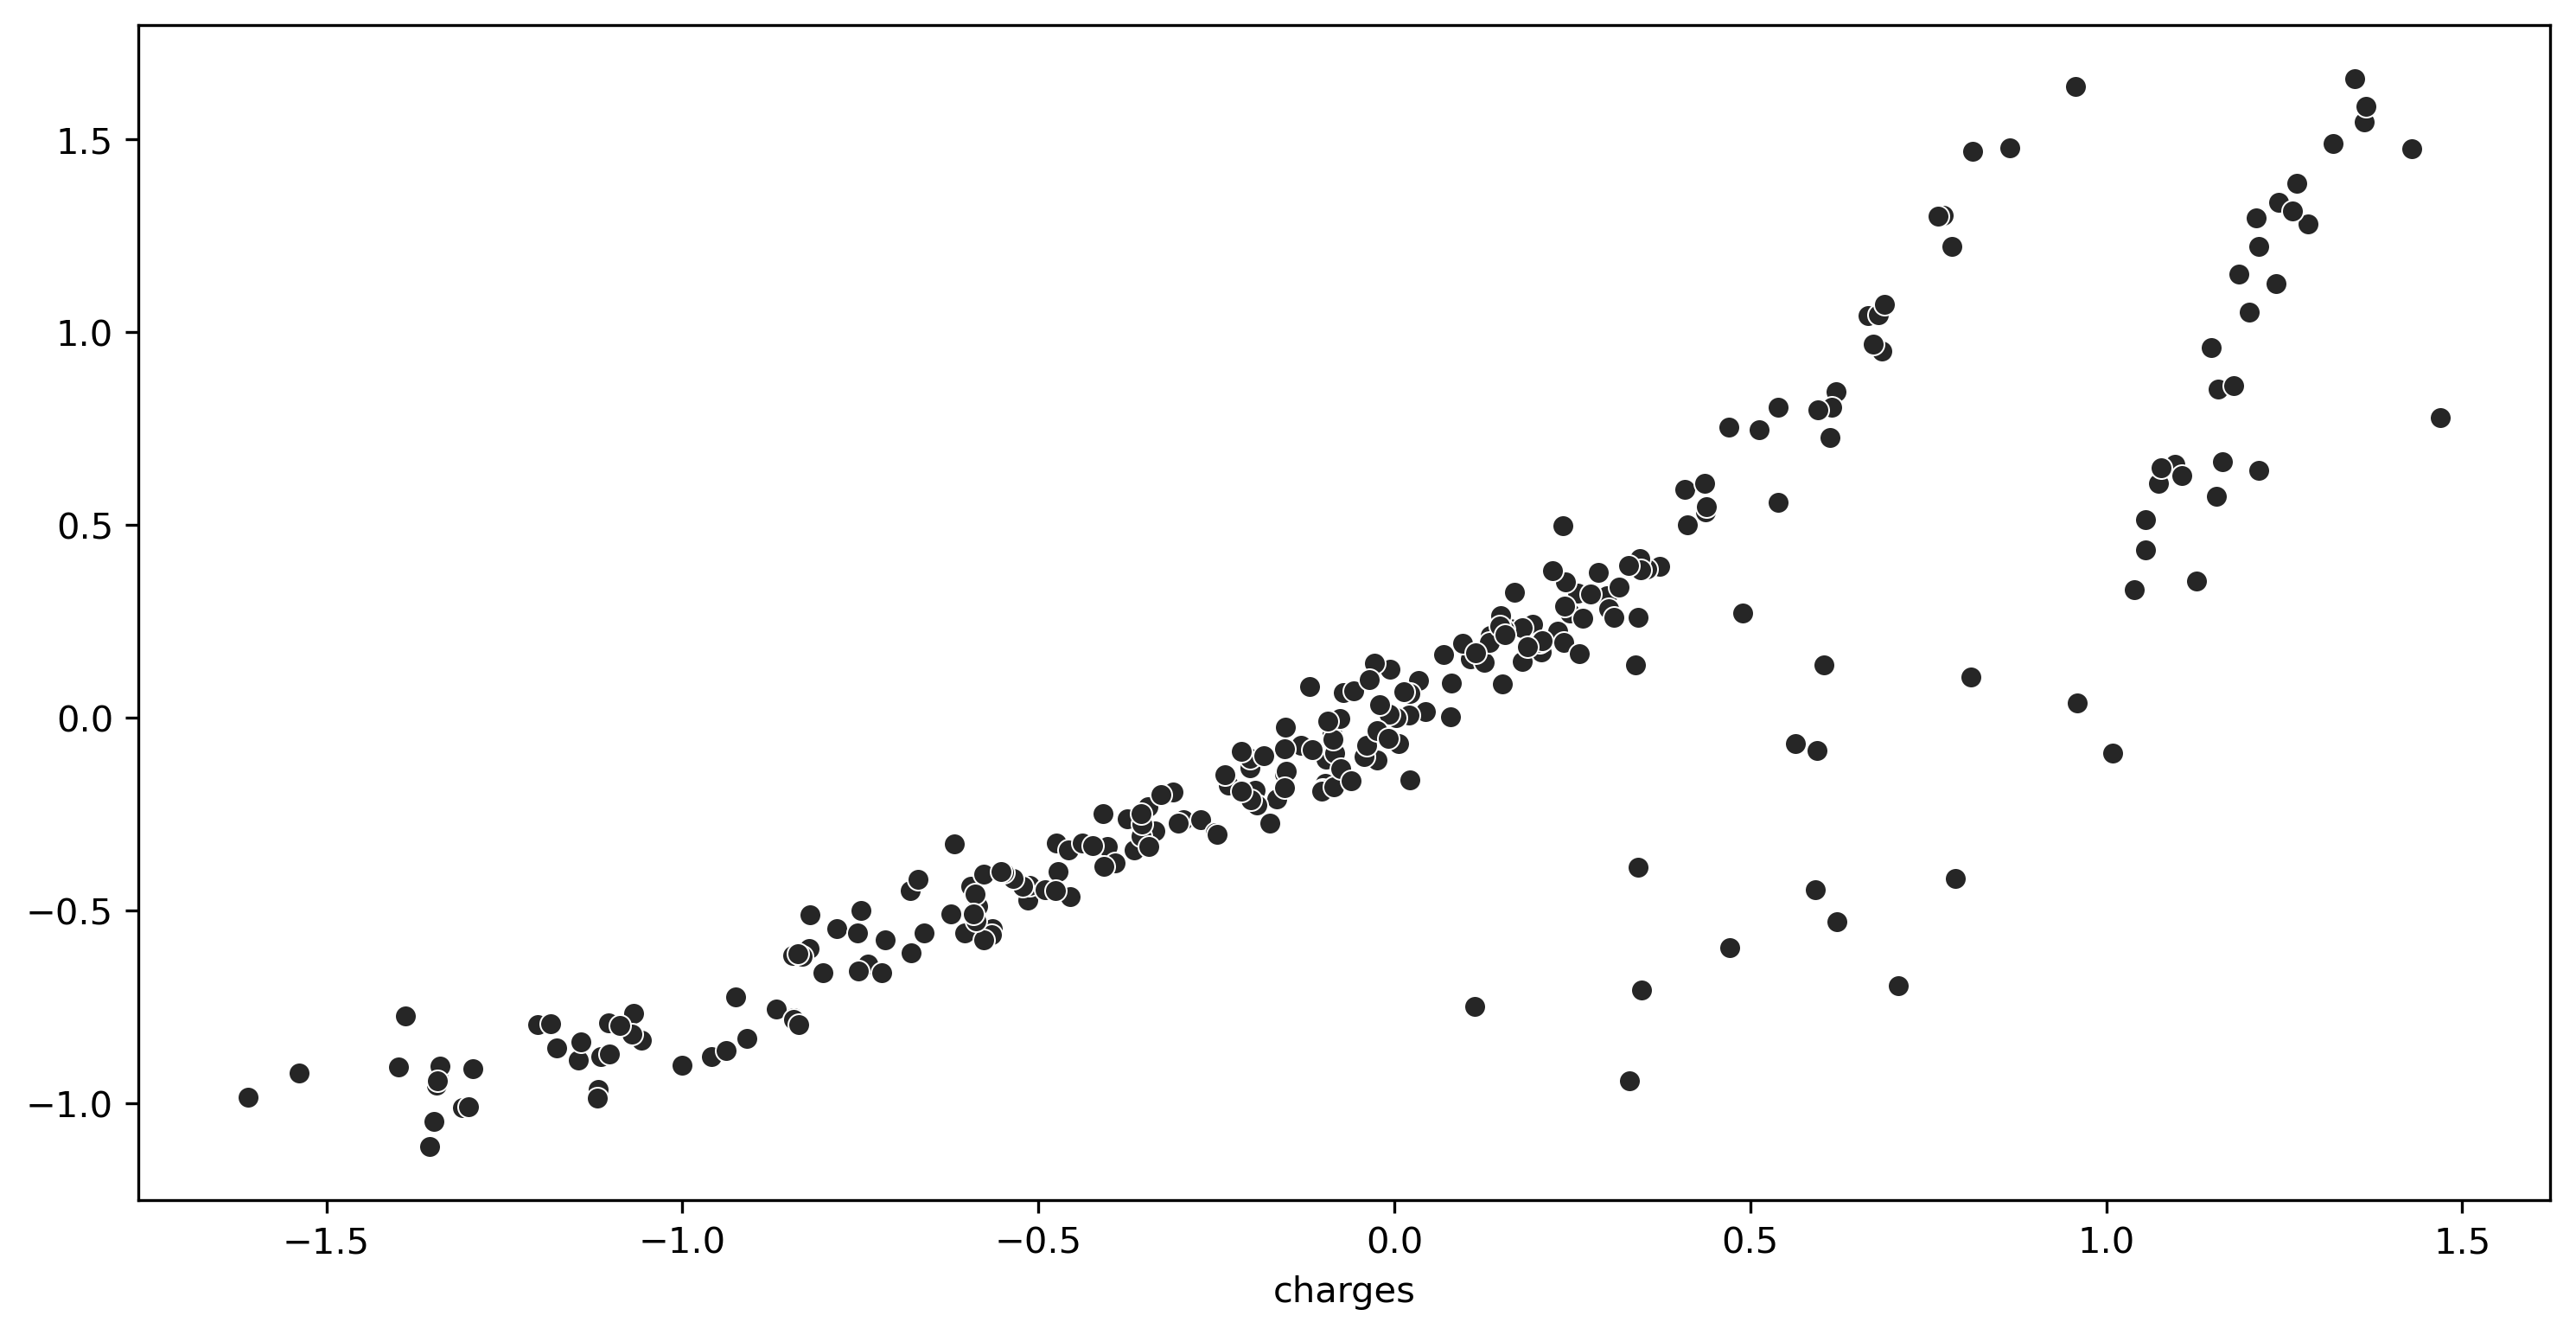

In [25]:
plt.figure(figsize=[12, 6], dpi=300)
sns.scatterplot(x=y_test, y=ols_predictions, color='#262626')
plt.savefig('../../demo/Model Creation/real vs predictions of OLS.png')
plt.show()

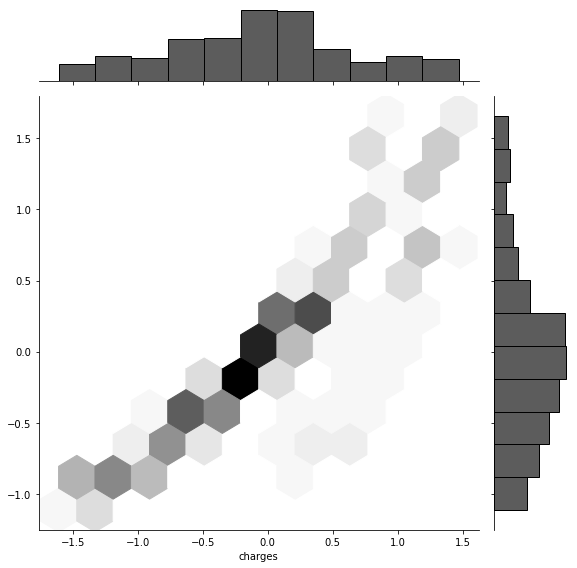

In [26]:
sns.jointplot(x=y_test, y=ols_predictions,
              height=8, color='#262626', kind='hex')
plt.savefig('../../demo/Model Creation/real vs predictions of OLS(hex).png')
plt.show()

****Ridge, Lasso, and ElasticNet regularization methods****

- Ridge

In [27]:
Ridge_model = Ridge(alpha=1)

In [28]:
cv = RepeatedKFold(n_repeats=5, n_splits=12, random_state=1)
scores_ridge = cross_val_score(Ridge_model, df, Y, cv=cv, scoring='r2')
ev_ridge = cross_val_score(Ridge_model, df, Y, cv=cv, scoring='explained_variance')
scores_ridge, ev_ridge

(array([0.75357657, 0.81154068, 0.77296164, 0.74707772, 0.71053936,
        0.80312838, 0.76098287, 0.66935154, 0.75280911, 0.73923356,
        0.71658262, 0.87441846, 0.80470274, 0.77276031, 0.63555009,
        0.67802579, 0.71912121, 0.71484174, 0.79678067, 0.8105941 ,
        0.75574922, 0.83180861, 0.84508887, 0.8357604 , 0.71460888,
        0.71258539, 0.73664407, 0.84577766, 0.85844478, 0.68535156,
        0.80863876, 0.68440181, 0.83598623, 0.69836144, 0.76622642,
        0.77770165, 0.80087567, 0.78013297, 0.79996007, 0.75612605,
        0.7395539 , 0.74547119, 0.81545476, 0.65403655, 0.77319677,
        0.80161452, 0.76776313, 0.74854015, 0.77744612, 0.77935828,
        0.71609747, 0.69605601, 0.75920547, 0.75607061, 0.71933112,
        0.68348667, 0.76292374, 0.78790941, 0.87929258, 0.8101753 ]),
 array([0.75493132, 0.81736474, 0.77363502, 0.74725044, 0.72040439,
        0.8106625 , 0.76125827, 0.67202675, 0.75329739, 0.74188668,
        0.71661582, 0.88130581, 0.80932389, 0.

In [29]:
print(f'average score: {np.mean(scores_ridge) * 100}\n'
      f'standard deviation: {np.std(scores_ridge)}')

avarage score: 76.24632231409821
standard deviation: 0.05458235097653901


**Explained variance**

In [30]:
print(f'average score: {np.mean(ev_ridge) * 100}\n'
      f'standard deviation: {np.std(ev_ridge)}')

avarage score: 76.50658423340055
standard deviation: 0.055106884376717076


*****Ridge tune hyper-parameter*****

In [31]:
ridge_tuning_model = Ridge()

# grid of values for search
grid = dict()
grid['alpha'] = np.arange(0, 1, 0.01)

# searching grid
grid_search = GridSearchCV(ridge_tuning_model, grid, scoring='r2', cv=cv)
result = grid_search.fit(df, Y)

In [32]:
result.best_index_, result.best_score_, result.best_params_, result.best_estimator_

(10, 0.7625433294592462, {'alpha': 0.1}, Ridge(alpha=0.1))

In [33]:
Ridge_model_best_alpha = Ridge(alpha=0.1)

In [34]:
cv_best_alpha = RepeatedKFold(n_repeats=5, n_splits=12, random_state=1)
scores_ridge_best_alpha = cross_val_score(Ridge_model_best_alpha, df, Y,
                                          cv=cv_best_alpha, scoring='r2')
scores_ridge_best_alpha

array([0.75432185, 0.81139265, 0.77259651, 0.74729117, 0.71242919,
       0.80228109, 0.76081339, 0.66793348, 0.75344341, 0.73959114,
       0.71588064, 0.87531556, 0.80426138, 0.77243271, 0.63542028,
       0.6763215 , 0.71901837, 0.71487975, 0.79600092, 0.81186238,
       0.75551292, 0.8324514 , 0.84647585, 0.83713015, 0.71421365,
       0.71238272, 0.73722415, 0.84724193, 0.85862658, 0.68550891,
       0.80784353, 0.68336051, 0.83650514, 0.69883696, 0.76632928,
       0.7777232 , 0.80226886, 0.77937964, 0.79966742, 0.75584385,
       0.74067399, 0.74615966, 0.81558329, 0.65216401, 0.77349804,
       0.8019695 , 0.76840048, 0.74824223, 0.77877942, 0.77931466,
       0.71704633, 0.69543566, 0.75775351, 0.75441642, 0.71786687,
       0.68381517, 0.76513729, 0.78887857, 0.87935961, 0.81009106])

In [35]:
print(f'average score: {np.mean(scores_ridge_best_alpha) * 100}\n'
      f'standard deviation: {np.std(scores_ridge_best_alpha)}')

avarage score: 76.25433294592462
standard deviation: 0.054910597243152816


- LASSO

In [36]:
Lasso_model = Lasso(alpha=1)

In [37]:
cv = RepeatedKFold(n_repeats=5, n_splits=12, random_state=1)
scores_Lasso = cross_val_score(Lasso_model, df, Y, cv=cv, scoring='r2')
scores_Lasso

array([-2.51148569e-02, -2.20038501e-02, -1.04189578e-02, -1.67579796e-03,
       -1.99433489e-02, -7.75268655e-02, -5.48971366e-03, -1.24292754e-02,
       -2.61303827e-03, -2.17025492e-02, -3.83164954e-03, -1.34785399e-02,
       -1.45325155e-02, -3.96852551e-03, -1.60449512e-02, -2.61335167e-04,
       -2.06460776e-03, -5.21404982e-03, -8.40699660e-04, -9.99989073e-03,
       -3.22704655e-02, -9.95565007e-03, -6.67840642e-03, -1.55331185e-03,
       -9.64190648e-04, -1.52083016e-03, -1.37203105e-04, -2.82740071e-03,
       -1.94621940e-02, -4.47721098e-02, -3.02900196e-03, -1.13755320e-03,
       -1.97913206e-03, -3.15144788e-02, -4.88104811e-03, -1.17467124e-03,
       -3.15061301e-05, -5.82668141e-03, -1.46785562e-02, -3.61343469e-05,
       -8.16251983e-03, -4.61693364e-05, -4.11351352e-05, -9.05561612e-03,
       -1.35039407e-03, -9.80290696e-05, -7.07374014e-03, -1.86597090e-05,
       -2.31421626e-02, -6.24095527e-03, -4.77921892e-03, -5.56464279e-03,
       -1.87552006e-03, -

In [38]:
print(f'average score: {np.mean(scores_Lasso) * 100}\n'
      f'standard deviation: {np.std(scores_Lasso)}')

avarage score: -0.9422136987256932
standard deviation: 0.012993947096910898


*****Lasso tune hyper-parameter*****

In [39]:
lasso_tuning_model = Lasso()

# searching grid
grid_search_lasso = GridSearchCV(lasso_tuning_model, grid, scoring='r2', cv=cv)
result_lasso = grid_search.fit(df, Y)

In [40]:
result_lasso.best_index_, result_lasso.best_score_, result_lasso.best_params_, result_lasso.best_estimator_

(10, 0.7625433294592462, {'alpha': 0.1}, Ridge(alpha=0.1))

- ElasticNet

In [41]:
en_model = ElasticNet(alpha=1, l1_ratio=0.5)

In [42]:
cv_en = RepeatedKFold(n_repeats=5, n_splits=12, random_state=1)
scores_en = cross_val_score(en_model, df, Y, cv=cv, scoring='r2')
scores_en

array([-2.51148569e-02, -2.20038501e-02, -1.04189578e-02, -1.67579796e-03,
       -1.99433489e-02, -7.75268655e-02, -5.48971366e-03, -1.24292754e-02,
       -2.61303827e-03, -2.17025492e-02, -3.83164954e-03, -1.34785399e-02,
       -1.45325155e-02, -3.96852551e-03, -1.60449512e-02, -2.61335167e-04,
       -2.06460776e-03, -5.21404982e-03, -8.40699660e-04, -9.99989073e-03,
       -3.22704655e-02, -9.95565007e-03, -6.67840642e-03, -1.55331185e-03,
       -9.64190648e-04, -1.52083016e-03, -1.37203105e-04, -2.82740071e-03,
       -1.94621940e-02, -4.47721098e-02, -3.02900196e-03, -1.13755320e-03,
       -1.97913206e-03, -3.15144788e-02, -4.88104811e-03, -1.17467124e-03,
       -3.15061301e-05, -5.82668141e-03, -1.46785562e-02, -3.61343469e-05,
       -8.16251983e-03, -4.61693364e-05, -4.11351352e-05, -9.05561612e-03,
       -1.35039407e-03, -9.80290696e-05, -7.07374014e-03, -1.86597090e-05,
       -2.31421626e-02, -6.24095527e-03, -4.77921892e-03, -5.56464279e-03,
       -1.87552006e-03, -

*****ElasticNet tune hyper-parameter*****

In [43]:
grid_en = dict()
grid_en['alpha'] = [1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 0.0, 1.0, 10.0, 100.0]
grid_en['l1_ratio'] = np.arange(0, 1, 0.01)

en_tuning_model = ElasticNet()

# searching grid
grid_search_en = GridSearchCV(en_tuning_model, grid_en, scoring='r2', cv=cv)
result_en = grid_search.fit(df, Y)

In [44]:
result_en.best_index_, result_en.best_estimator_, result_en.best_score_, result_en.best_params_, result_en.multimetric_

(10, Ridge(alpha=0.1), 0.7625433294592462, {'alpha': 0.1}, False)

In [45]:
lasso_model = Lasso(alpha=0.1).fit(x_train, y_train)
ridge_model = Ridge(alpha=0.1).fit(x_train, y_train)
elasticnet_model = ElasticNet(alpha=0.1, l1_ratio=0).fit(x_train, y_train)

l1_prediction = lasso_model.predict(x_test)
l2_prediction = ridge_model.predict(x_test)
en_prediction = elasticnet_model.predict(x_test)

c:\users\ashen\appdata\local\programs\python\python37\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 173.0834347983396, tolerance: 0.05811076628173603
  positive)


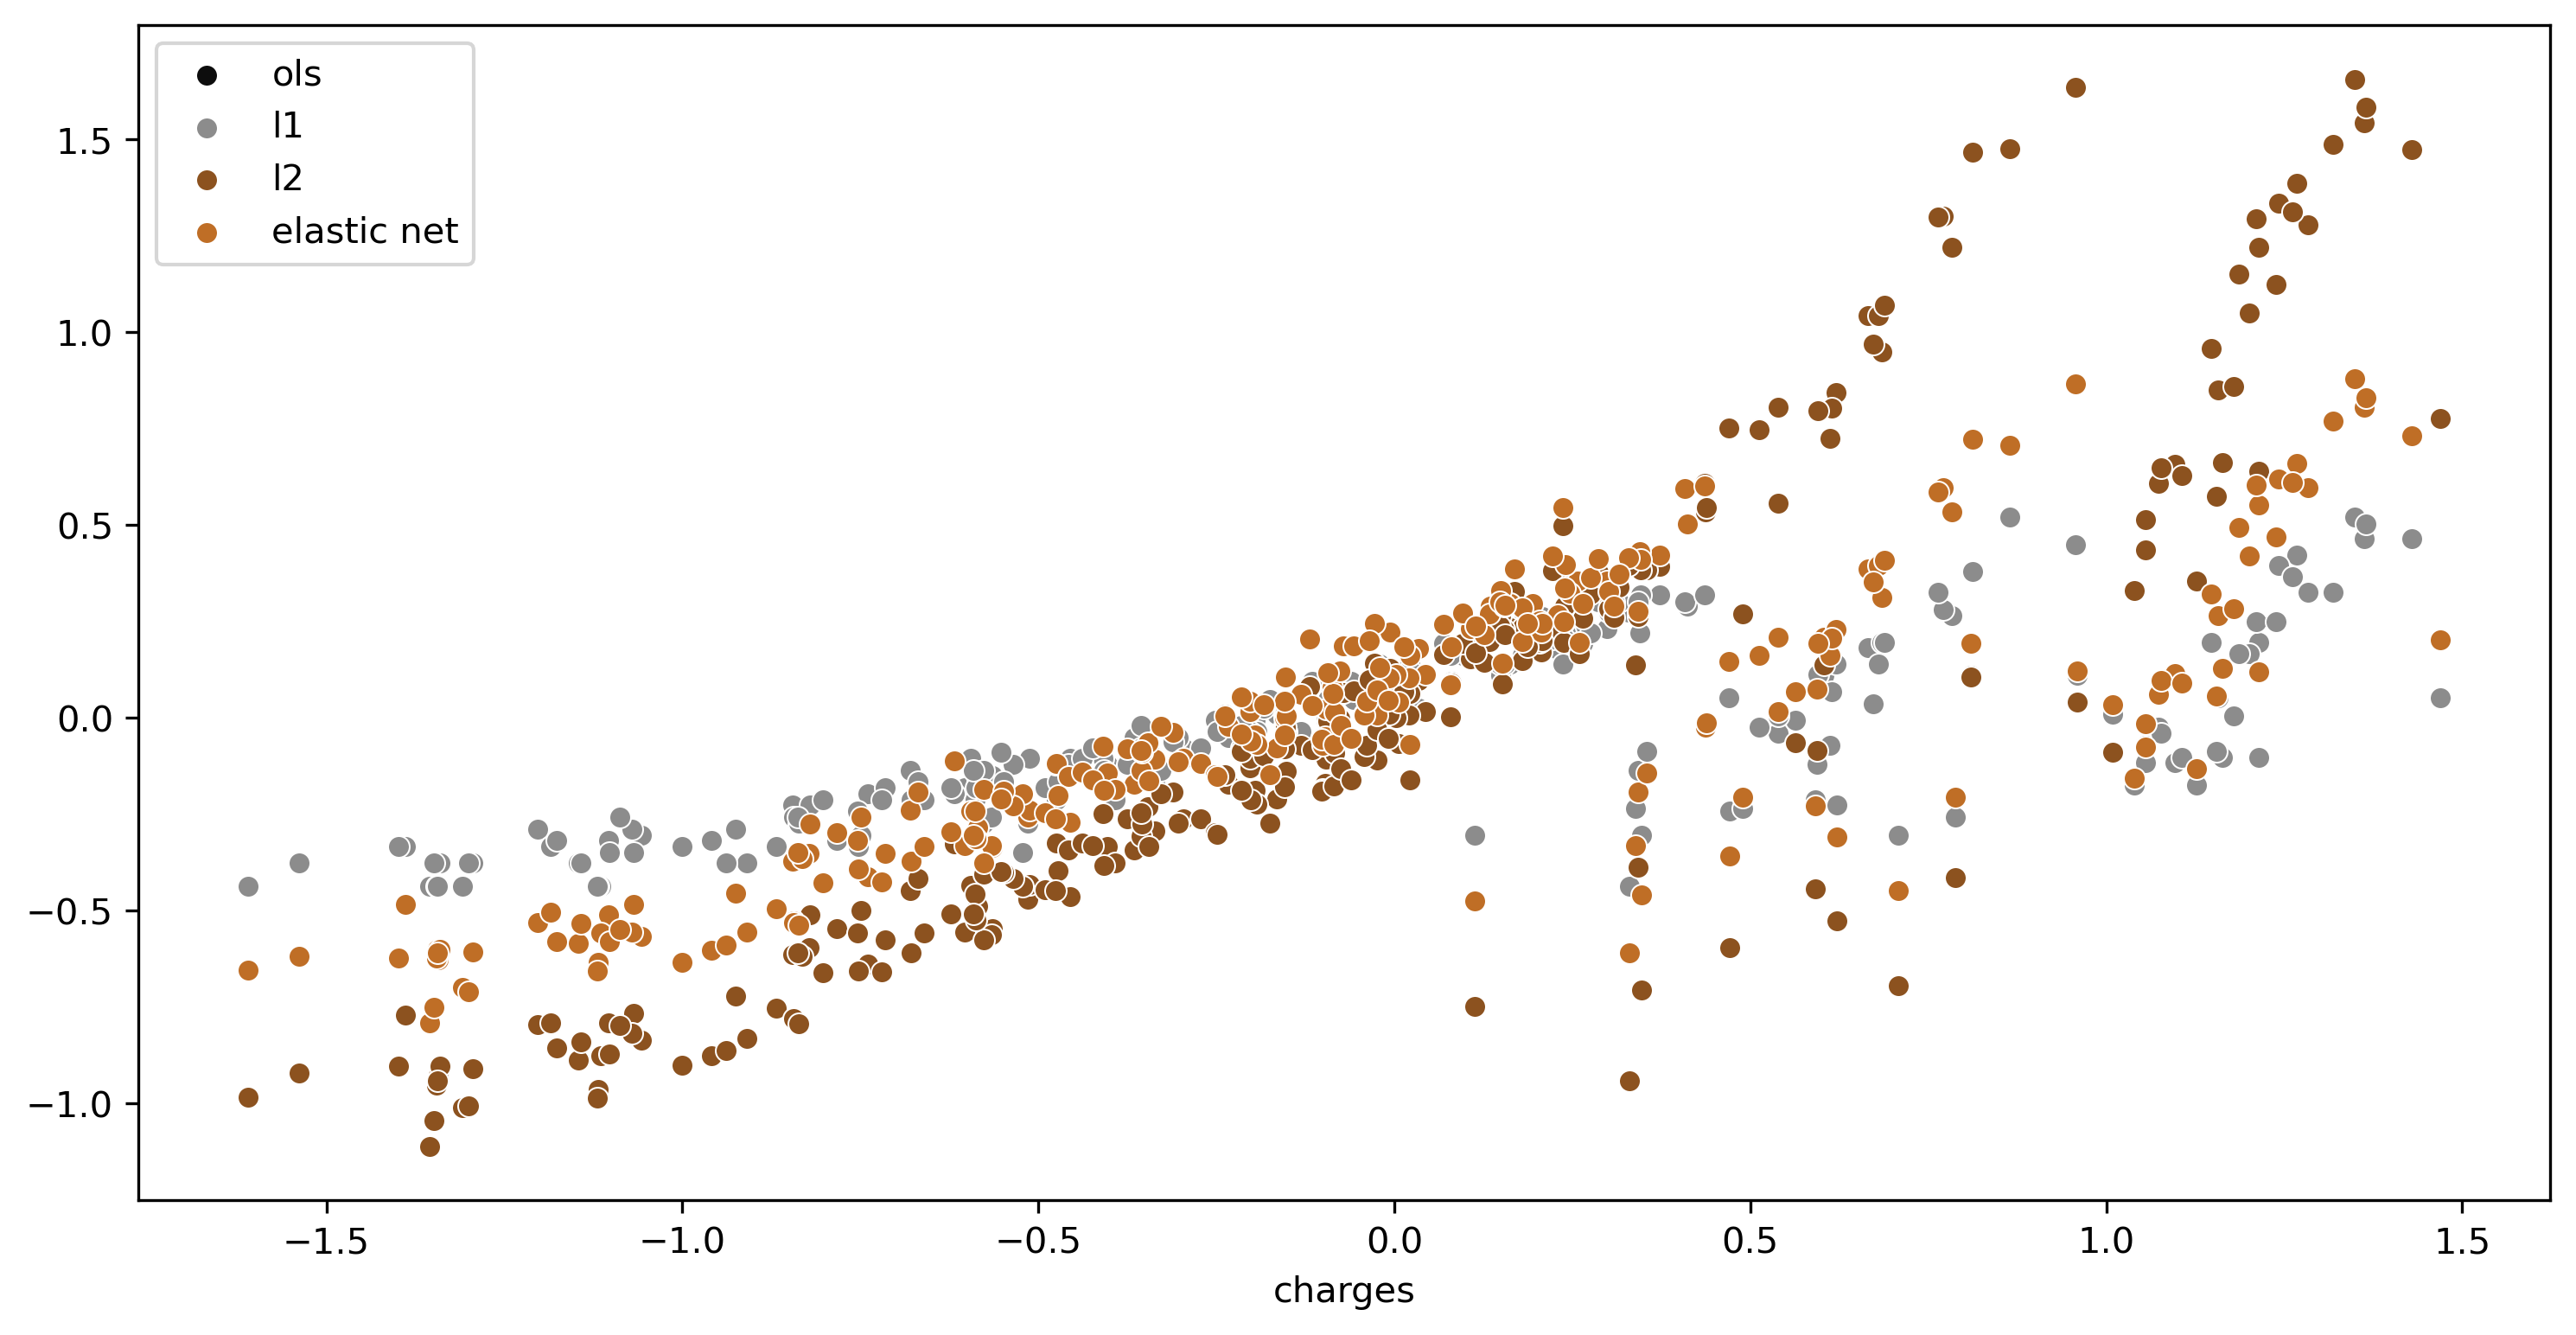

In [46]:
plt.figure(figsize=[12, 6], dpi=300)
sns.scatterplot(x=y_test, y=ols_predictions, color='#0D0D0D', label='ols')
sns.scatterplot(x=y_test, y=l1_prediction, color='#8C8C8C', label='l1')
sns.scatterplot(x=y_test, y=l2_prediction, color='#8C521F', label='l2')
sns.scatterplot(x=y_test, y=en_prediction, color='#BF6E26', label='elastic net')
plt.legend()
plt.savefig('../../demo/Model Creation/compare real vs regularization.png')
plt.show()

- RANSAC

In [67]:
ransac_model = RANSACRegressor(base_estimator=ridge_model,
                               min_samples=5)

In [68]:
cv_ransac = RepeatedKFold(n_repeats=3, n_splits=3, random_state=1)
scores_ransac = cross_val_score(ransac_model, df, Y, cv=cv, scoring='r2')
scores_ransac

array([0.56773939, 0.79503342, 0.78024046, 0.47926727, 0.65063725,
       0.78419944, 0.66236551, 0.56563868, 0.68509748, 0.55853865,
       0.69922469, 0.88539099, 0.77990567, 0.57048137, 0.52267106,
       0.6236043 , 0.60056687, 0.59573355, 0.77862601, 0.81245965,
       0.6587542 , 0.68683112, 0.78838185, 0.82701506, 0.60463382,
       0.61735497, 0.65435162, 0.84340954, 0.88790118, 0.63440701,
       0.80885787, 0.68559018, 0.72659578, 0.48301883, 0.75438029,
       0.32754776, 0.68978321, 0.73128558, 0.71021849, 0.61762769,
       0.63614178, 0.51805575, 0.70160688, 0.59015751, 0.74878616,
       0.78399449, 0.6676003 , 0.55043776, 0.60779282, 0.57159426,
       0.61705815, 0.67167497, 0.69536466, 0.75794308, 0.68537048,
       0.53040836, 0.6829582 , 0.64216832, 0.82744898, 0.74354389])

In [66]:
print(f'average score: {np.mean(scores_ransac) * 100}\n'
      f'standard deviation: {np.std(scores_ransac)}')

avarage score: 56.029813860588064
standard deviation: 0.21618227557459735


In [59]:
ransac_model.fit(x_train, y_train)
ransac_prediction = ransac_model.predict(x_test)

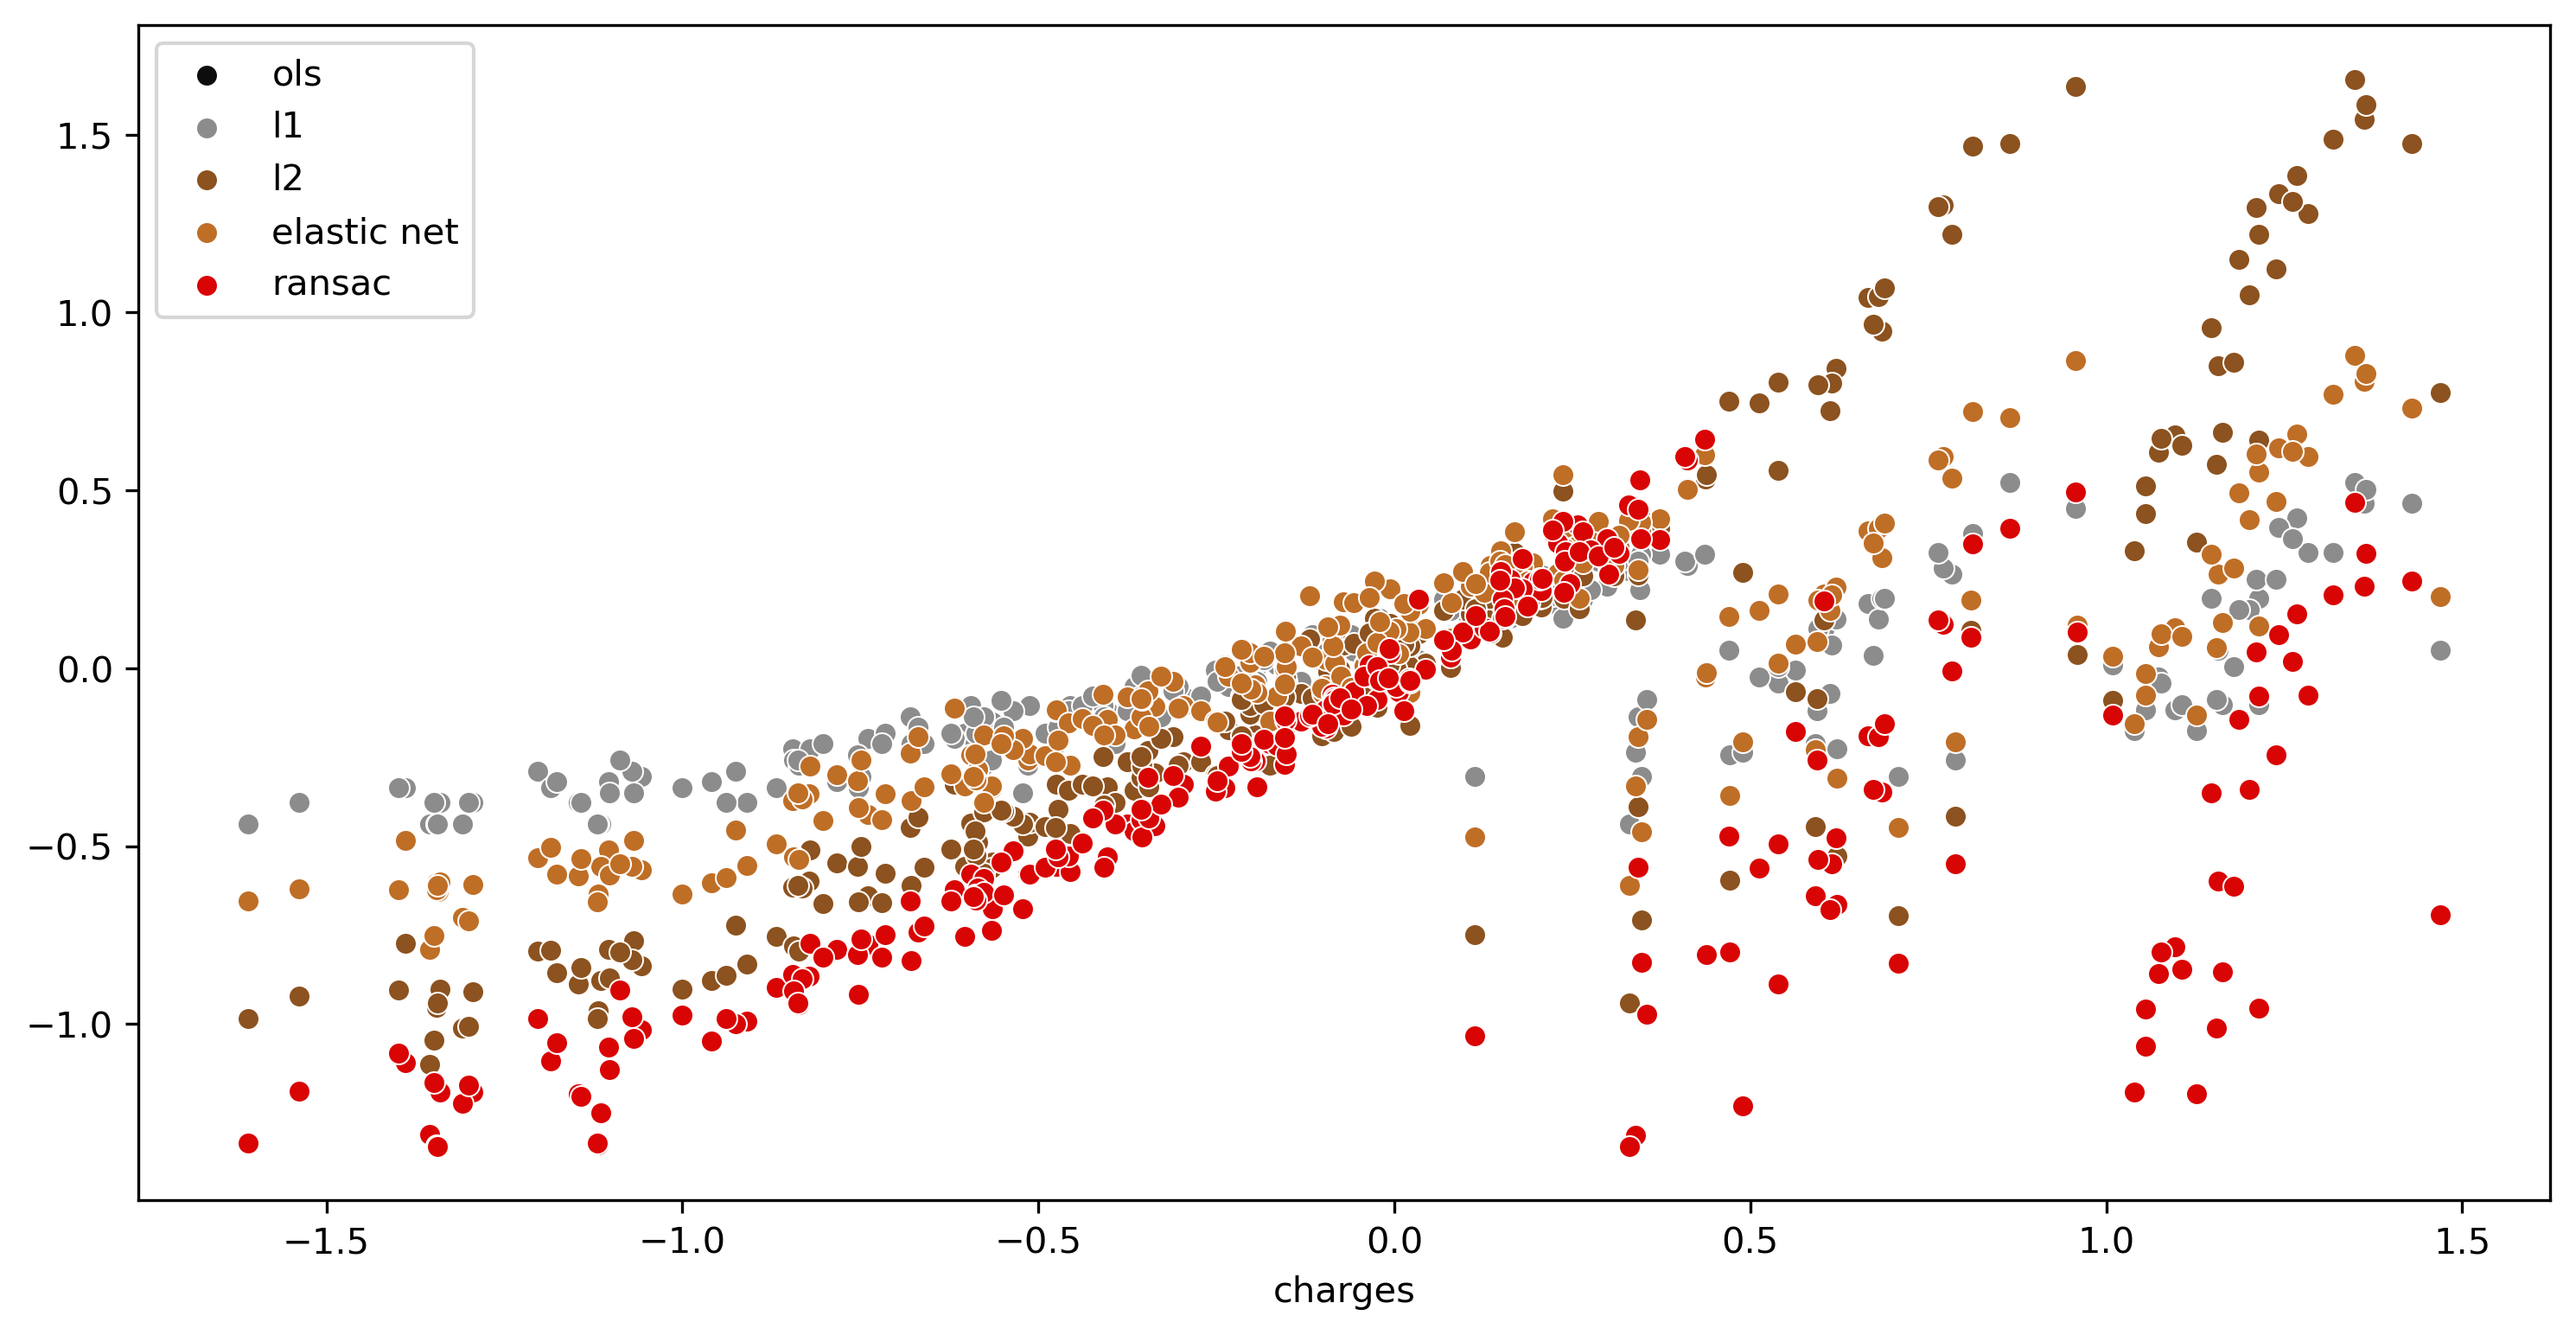

In [60]:
plt.figure(figsize=[12, 6], dpi=300)

sns.scatterplot(x=y_test, y=ols_predictions, color='#0D0D0D', label='ols')
sns.scatterplot(x=y_test, y=l1_prediction, color='#8C8C8C', label='l1')
sns.scatterplot(x=y_test, y=l2_prediction, color='#8C521F', label='l2')
sns.scatterplot(x=y_test, y=en_prediction, color='#BF6E26', label='elastic net')
sns.scatterplot(x=y_test, y=ransac_prediction, color='#D90404', label='ransac')

plt.legend()
plt.savefig('../../demo/Model Creation/compare real_regularization_robust.png')
plt.show()

- Huber

In [69]:
huber_model = HuberRegressor()

In [70]:
cv_huber = RepeatedKFold(n_repeats=3, n_splits=3, random_state=1)
scores_huber = cross_val_score(huber_model, df, Y, cv=cv, scoring='r2')
scores_huber

array([0.7313706 , 0.81404361, 0.77918084, 0.71002358, 0.67130482,
       0.80384023, 0.74232898, 0.64398388, 0.73737428, 0.70478287,
       0.68847368, 0.88564223, 0.80175039, 0.76296254, 0.57839197,
       0.64142682, 0.70229954, 0.69864862, 0.77370467, 0.81114577,
       0.72713156, 0.82311063, 0.85551013, 0.8384094 , 0.69216736,
       0.68632085, 0.69871644, 0.85305175, 0.88293815, 0.6334406 ,
       0.79674221, 0.6451968 , 0.83373819, 0.6629767 , 0.76906655,
       0.75956984, 0.79313049, 0.75339144, 0.7762158 , 0.73620884,
       0.69739871, 0.74363916, 0.79824277, 0.62090771, 0.75851066,
       0.8070445 , 0.75976004, 0.73548337, 0.74006814, 0.76611187,
       0.69168808, 0.6754223 , 0.72845062, 0.75517173, 0.70356903,
       0.64426721, 0.73690491, 0.78221018, 0.89007393, 0.8079015 ])

In [71]:
print(f'average score: {np.mean(scores_huber) * 100}\n'
      f'standard deviation: {np.std(scores_huber)}')


avarage score: 74.5709001169075
standard deviation: 0.06883701860873503
